# **Projet Machine Learning - Sentiment Analysis of Movie Reviews 🎬** 

## **Scraping** 

https://colab.research.google.com/drive/13zcGvhVsHCdp4nuYRHlh8XG8HdYWnJKY?usp=sharing

## **1 - Import** 

In [1]:
# Manipulation des données
import pandas as pd
import numpy as np
import shutil
import os

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Traitement du texte (NLP)
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer


# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score


Lancement Expérimentation

In [3]:
#A mettre dans la console
#!mlflow server --host 127.0.0.1 --port 8080

In [5]:
from mlflow import MlflowClient
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor

In [3]:
# In order to connect to the tracking server, we’ll need to use the uri that we assigned the server when we started it.

client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

#it allows programmatic interaction with the MLflow tracking server.

In [ ]:
import mlflow

# Sets the current active experiment to the "Apple_Models" experiment and
# returns the Experiment metadata
Sentiment_analysis_experiment = mlflow.set_experiment("Sentiment_Analysis")

# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "Sentiment_analysis_lr_2"

# Define an artifact path that the model will be saved to.
artifact_path = "lr_sentiment"


In [11]:
all_experiments = client.search_experiments()

print(all_experiments)

[<Experiment: artifact_location='file:///c:/Users/pierr/Desktop/Formation_Data/11_ML_OPS/Projet/mlruns/233455943930252282', creation_time=1742148191554, experiment_id='233455943930252282', last_update_time=1742148191554, lifecycle_stage='active', name='Sentiment_Analysis', tags={}>, <Experiment: artifact_location='mlflow-artifacts:/403589454758229097', creation_time=1742142384662, experiment_id='403589454758229097', last_update_time=1742142384662, lifecycle_stage='active', name='Sentiment_analysis', tags={}>, <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1742142344110, experiment_id='0', last_update_time=1742142344110, lifecycle_stage='active', name='Default', tags={}>]


In [13]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "This is a Sentiment Analysis program."
)

# Create the Experiment, providing a unique name
Sentiment_analysis_experiment = client.create_experiment(
    name="Sentiment_analysis_170325"
)

## **2 - Chargement des données**

In [14]:
df = pd.read_csv('all_film_reviews.csv', sep=';', encoding='Windows-1252')

df.head()


,Note,Description,Film_Name
0,4,Après avoir vu ce fameux Oppenheimer en 70mm :...,Oppenheimer
1,3,"3,25/5. J'ai du mal à comprendre certains supe...",Oppenheimer
2,2,"Beaucoup, beaucoup, beaucoup de dialogues.Beau...",Oppenheimer
3,2,"Franchement, très déçu de ce dernier film de C...",Oppenheimer
4,"3,5",Oppenheimer nous permet d'en savoir beaucoup p...,Oppenheimer


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55479 entries, 0 to 55478
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Note         55479 non-null  object
 1   Description  39530 non-null  object
 2   Film_Name    55479 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


## **3 - Exploration des données (EDA)**

### Suppression des avis vides (NaN) avant l'analyse

In [16]:
df = df.dropna(subset=["Description"])
print(f"Nombre de lignes après suppression des NaN dans 'Description' : {df.shape[0]}")


Nombre de lignes après suppression des NaN dans 'Description' : 39530


### Analyse de la distribution des notes

Notes après supressions des avis vides 

Note
0,5     2485
1       1704
1,5     1107
2       2752
2,5     2293
3       3135
3,5     3694
4       6417
4,5     5878
5      10065
Name: count, dtype: int64


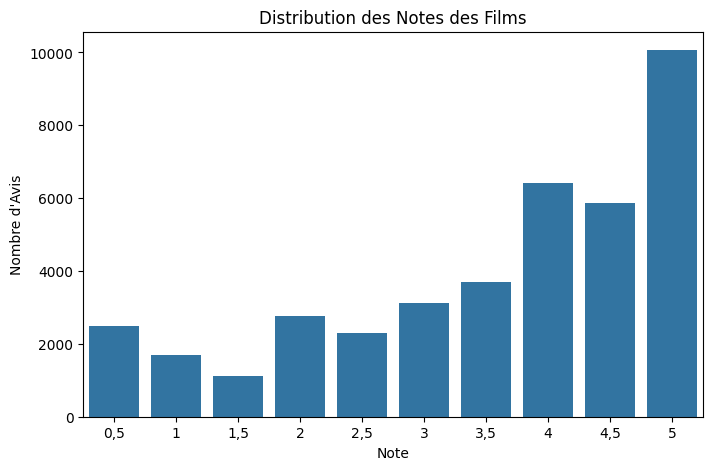

In [17]:
note_counts = df["Note"].value_counts().sort_index()
print(note_counts)

plt.figure(figsize=(8,5))
sns.barplot(x=note_counts.index, y=note_counts.values, order=note_counts.index)
plt.title("Distribution des Notes des Films")
plt.xlabel("Note")
plt.ylabel("Nombre d'Avis")
plt.show()

## **4 - Prétraitement des textes**

### Nettoyage + conversion en minuscule

In [18]:
def nettoyer_texte_brut(text):
    text = text.lower()  # minuscules
    text = re.sub(r'[^a-zA-Zéèêëàâîïôöùûüç\s]', ' ', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    return text
    
df["Clean_Description"] = df["Description"].astype(str).apply(nettoyer_texte_brut)

df[["Description", "Clean_Description"]].sample(5)


,Description,Clean_Description
15095,"Une ode à Tom Cruise, et un navet larmoyant ...",une ode à tom cruise et un navet larmoyant de ...
1037,"Nolan se lance dans une nouvelle aventure, his...",nolan se lance dans une nouvelle aventure hist...
52547,"Très bon film, scénario, visuels, musiques, ac...",très bon film scénario visuels musiques acteur...
41318,"Un film qui dure en longueur, des scènes extrê...",un film qui dure en longueur des scènes extrêm...
14508,Dès les premières notes le frisson ! Les image...,dès les premières notes le frisson les images ...


### Suppression des stopwords

In [19]:
nltk.download("stopwords")

stop_words = set(stopwords.words("french"))

def supprimer_stopwords(text):
    words = text.split()  
    words = [word for word in words if word.lower() not in stop_words]  
    return " ".join(words)  

df["Clean_Description"] = df["Clean_Description"].astype(str).apply(supprimer_stopwords)

df[["Description", "Clean_Description"]].sample(5)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pierr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Description,Clean_Description
1911,Que dire de plus sur ce nouveau chef d'oeuvre ...,dire plus nouveau chef oeuvre nolan film dure ...
16344,Le début était un peu lent mais quand ça a com...,début peu lent quand ça a commencé captivant t...
16313,Un des meilleurs films que j’ai pu voir au cin...,meilleurs films pu voir cinéma depuis plusieur...
55014,"Comme toujours chez Pixar, les images sont mag...",comme toujours chez pixar images magnifiques u...
13720,note maximale attribuée en toute subjectivité ...,note maximale attribuée toute subjectivité fan...


### Tokenisation des avis

In [20]:
def tokeniser_text(text):
    return word_tokenize(text)  

df["Tokenized_Description"] = df["Clean_Description"].astype(str).apply(tokeniser_text)

df[["Description", "Clean_Description", "Tokenized_Description"]].sample(5)

,Description,Clean_Description,Tokenized_Description
25431,"Ce film est à mes yeux un désastre, vu la trip...",film yeux désastre vu tripotée bons acteurs vu...,"[film, yeux, désastre, vu, tripotée, bons, act..."
3135,INCROYABLE EMMA STONE ! J'espère qu'elle aura ...,incroyable emma stone espère oscar meilleure a...,"[incroyable, emma, stone, espère, oscar, meill..."
7142,Le scénario du film part un peu dans tous les ...,scénario film part peu tous sens perd guerre s...,"[scénario, film, part, peu, tous, sens, perd, ..."
41331,"Tarantino a été en grande forme pour ce film, ...",tarantino a grande forme film balade bout bout...,"[tarantino, a, grande, forme, film, balade, bo..."
38365,1917 fait partie des rares films qu'il faut AB...,fait partie rares films faut absolument voir c...,"[fait, partie, rares, films, faut, absolument,..."


### Lemmatisation des mots 

In [21]:
#Take 1min

try:
    nlp = spacy.load("fr_core_news_sm", disable=["parser", "ner"])  
except OSError:
    import spacy.cli
    spacy.cli.download("fr_core_news_sm")
    nlp = spacy.load("fr_core_news_sm", disable=["parser", "ner"])


def lemmatizetexts(texts):
    texts = [str(text) for text in texts]  # Conversion en string
    return [" ".join([token.lemma_ for token in doc]) for doc in nlp.pipe(texts, batch_size=50, n_process=2)]


df['Clean_Description'] = lemmatizetexts(df['Clean_Description'].astype(str).tolist())

print(df[['Description', 'Clean_Description']].head())

                                         Description  \
0  Après avoir vu ce fameux Oppenheimer en 70mm :...   
1  3,25/5. J'ai du mal à comprendre certains supe...   
2  Beaucoup, beaucoup, beaucoup de dialogues.Beau...   
3  Franchement, très déçu de ce dernier film de C...   
4  Oppenheimer nous permet d'en savoir beaucoup p...   

                                   Clean_Description  
0  après avoir voir fameu oppenheimer millimètre ...  
1  mal comprendre certain superlatif propo film t...  
2  beaucoup beaucoup beaucoup dialogue beaucoup b...  
3  franchement très déçu dernier film christopher...  
4  oppenheimer permettre savoir beaucoup plus inv...  


## **5 - Annotation et définition des labels**

- Positif : Note ≥ 4
- Négatif : Note < 4

In [22]:
print("Valeurs uniques dans 'Note' avant conversion :", df["Note"].unique())


Valeurs uniques dans 'Note' avant conversion : ['4' '3' '2' '3,5' '2,5' '5' '0,5' '1' '1,5' '4,5']


Sentiment
Positif    22360
Négatif    17170
Name: count, dtype: int64


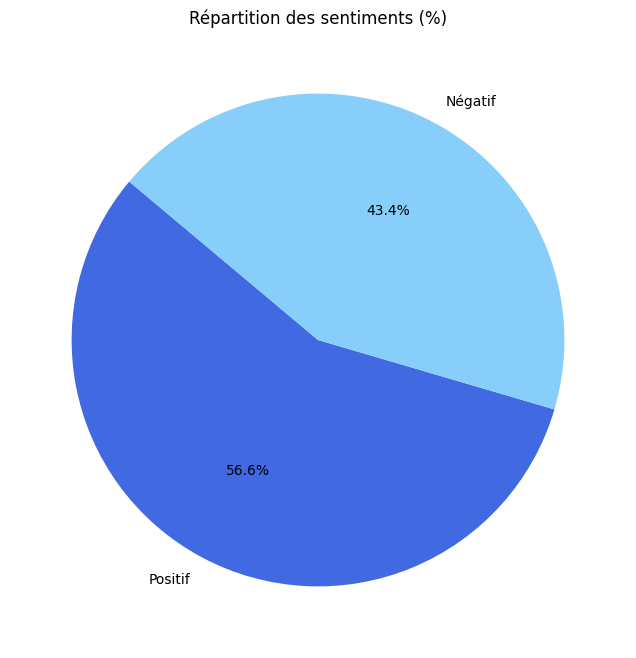

In [23]:
df["Note"] = df["Note"].astype(str).str.replace(",", ".").astype(float) # -> conversion en float

def assigner_sentiment(note):
    if pd.isna(note):
        return "Inconnu"
    elif note >= 4:
        return "Positif"
    else:
        return "Négatif"

df["Sentiment"] = df["Note"].apply(assigner_sentiment)

print(df["Sentiment"].value_counts())

df["Sentiment"] = df["Note"].apply(assigner_sentiment)

#-------------------------------------------------------------#



sentiment_counts = df["Sentiment"].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#4169E1', '#87CEFA'])
plt.title("Répartition des sentiments (%)")
plt.show()

## **6 - Vectorisation des textes**

### **TfidfVectorizer (TF-IDF)**

### Ce code transforme les descriptions de films en une matrice numérique (TF-IDF) où chaque description est représentée par un vecteur basé sur l'importance des mots, après un nettoyage du texte et l'exclusion des mots fréquents peu pertinents, pour faciliter l'analyse ou l'entraînement de modèles.

In [24]:

vectorizer_tfidf = TfidfVectorizer(
    token_pattern=r'\b[a-zA-ZÀ-ÖØ-öø-ÿ]{3,}\b',  # Exclut les nombres et les mots < 3 lettres
    ngram_range=(1, 2),  # Unigrammes et bigrammes
    max_features=50000,  # Garde les 50 000 mots les plus fréquents
    max_df=0.85,  # Ignore les mots présents dans plus de 85% des documents
    min_df=10  # Ignore les mots présents dans moins de 10 documents
)

X_tfidf = vectorizer_tfidf.fit_transform(df["Clean_Description"])

print(f"Shape de la matrice TF-IDF : {X_tfidf.shape}")

print("Quelques mots du vocabulaire :", vectorizer_tfidf.get_feature_names_out()[:10])

Shape de la matrice TF-IDF : (39530, 34653)
Quelques mots du vocabulaire : ['aaron' 'aaron sorkin' 'abandon' 'abandonn' 'abandonner'
 'abandonner tout' 'abandonné' 'abasourdi' 'abattre' 'aberration']


### Moyenne des valeurs TF-IDF par mot

In [25]:
tfidf_means = np.mean(X_tfidf.toarray(), axis=0)

top_words = np.argsort(tfidf_means)[-50:][::-1]
print("50 mots ou expressions les plus significatifs selon TF-IDF :", vectorizer_tfidf.get_feature_names_out()[top_words])
print("Scores TF-IDF moyens correspondants :", tfidf_means[top_words])

top_words_df = pd.DataFrame({"Mot": vectorizer_tfidf.get_feature_names_out()[top_words], "Score_TFIDF": tfidf_means[top_words]})
print(top_words_df.head(10))

50 mots ou expressions les plus significatifs selon TF-IDF : ['film' 'avoir' 'tout' 'très' 'bien' 'voir' 'plus' 'faire' 'acteur' 'bon'
 'pouvoir' 'histoire' 'peu' 'sans' 'scène' 'grand' 'comme' 'long'
 'scénario' 'trop' 'être' 'personnage' 'vraiment' 'passer' 'heure' 'cela'
 'aller' 'aussi' 'premier' 'cinéma' 'fin' 'beaucoup' 'rien' 'dire'
 'excellent' 'chef' 'fois' 'très bon' 'moment' 'mettre' 'bel' 'image'
 'autre' 'prendre' 'magnifique' 'temps' 'uvre' 'incroyable' 'vie' 'celui']
Scores TF-IDF moyens correspondants : [0.04500212 0.02784338 0.02494661 0.0239318  0.02017767 0.02017
 0.01959432 0.01863523 0.01706101 0.01675839 0.01529493 0.01505901
 0.01304592 0.0130097  0.01276545 0.01228731 0.01204989 0.01197893
 0.01188909 0.0117688  0.01127587 0.01114801 0.01052036 0.01045145
 0.01038401 0.0102951  0.01029068 0.00980105 0.00975757 0.00968667
 0.0094796  0.00910933 0.00890939 0.00882251 0.00862677 0.00805603
 0.00800326 0.00789037 0.00784889 0.00783464 0.00765764 0.00761131
 0.007589

In [26]:
from sklearn.preprocessing import LabelEncoder

# Initialiser l'encodeur
label_encoder = LabelEncoder()

# Transformer la colonne "Sentiment"
df["Sentiment_encoded"] = label_encoder.fit_transform(df["Sentiment"])

# Vérifier l'encodage
print(df[["Sentiment", "Sentiment_encoded"]].head())


  Sentiment  Sentiment_encoded
0   Positif                  1
1   Négatif                  0
2   Négatif                  0
3   Négatif                  0
4   Négatif                  0


## **7 - Construction et entraînement des modèles**

### Séparation des données en train et test (train_test_split)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(
    X_tfidf, df["Sentiment_encoded"], test_size=0.2, random_state=42, stratify=df["Sentiment_encoded"]
)

print(f"Taille du train set : {X_train.shape}")
print(f"Taille du test set : {X_val.shape}")


Taille du train set : (31624, 34653)
Taille du test set : (7906, 34653)


#### **Ce code divise les données vectorisées (X_tfidf) et leurs étiquettes ("Sentiment") en deux ensembles :**

#### - 80% pour l'entraînement (X_train, y_train) afin d'entraîner le modèle.
#### - 20% pour le test (X_test, y_test) afin d'évaluer ses performances sur des données inédites.
#### L'option stratify=df["Sentiment"] garantit que la répartition des classes (positif/négatif) est préservée dans les deux ensembles, ce qui permet d'obtenir une évaluation plus fiable.

### LogisticRegression (régression logistique)

Régression Logistique - Accuracy : 0.8660511004300532
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.84      3434
           1       0.86      0.90      0.88      4472

    accuracy                           0.87      7906
   macro avg       0.87      0.86      0.86      7906
weighted avg       0.87      0.87      0.87      7906



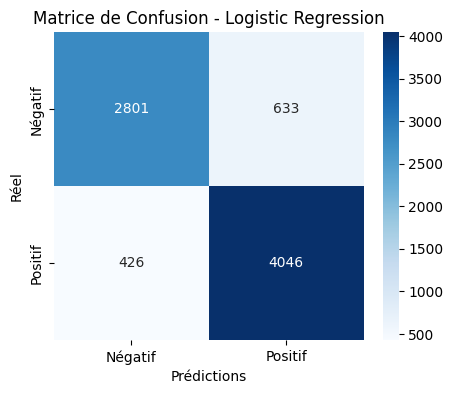

In [28]:
# random_state pour la reproductibilité et max_iter pour la convergence
model_lr = LogisticRegression(random_state=42, max_iter=1000)

model_lr.fit(X_train, y_train)

predictions_lr = model_lr.predict(X_val)

#Accuracy
accuracy_lr = accuracy_score(y_val, predictions_lr)
print("Régression Logistique - Accuracy :", accuracy_lr)

#Rapport de classification
print("Classification Report:\n", classification_report(y_val, predictions_lr))

#Matrice
cm = confusion_matrix(y_val, predictions_lr)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Négatif", "Positif"], yticklabels=["Négatif", "Positif"])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de Confusion - Logistic Regression")
plt.show()


In [29]:

import mlflow
import mlflow.sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict on the validation set
y_pred = model_lr.predict(X_val)

# Calculate error metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

# Assemble the metrics we're going to write into a collection
metrics = {"mae": mae, "mse": mse, "rmse": rmse, "r2": r2}

# Initiate the MLflow run context
with mlflow.start_run(run_name=run_name) as run:
    # Log the parameters used for the model fit
    #mlflow.log_params(params)

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

    # Log an instance of the trained model for later use
    mlflow.sklearn.log_model(
        sk_model=model_lr, input_example=X_val, artifact_path=artifact_path
    )


c:\Users\pierr\Desktop\Formation_Data\11_ML_OPS\Projet\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [ ]:
#import pickle

#with open("model_lr.pkl", "wb") as model_file:
#    pickle.dump(model_lr, model_file)

#with open("tfidf_vectorizer.pkl", "wb") as vectorizer_file:
#    pickle.dump(vectorizer_tfidf, vectorizer_file)


#### Le modèle de **Régression Logistique** affiche une **accuracy de 86,6%**, avec une bonne précision et un F1-score équilibré. Il détecte bien les avis positifs (91% de rappel) mais a plus de mal avec les négatifs (81%), entraînant des erreurs d’interprétation. La matrice de confusion met en évidence ces faux positifs et négatifs, suggérant qu'un ajustement des seuils ou un modèle plus avancé pourrait améliorer la classification.

### RandomForestClassifier (forêt aléatoire)

In [ ]:
from sklearn.model_selection import cross_val_score

model_rf = RandomForestClassifier(
    n_estimators=200,      # Plus d'arbres pour plus de stabilité
    max_depth=30,          # éviter le sur-apprentissage
    random_state=42,       # reproductibilité
    class_weight="balanced"  
)
#CV Score
cv_scores = cross_val_score(model_rf, X_train, y_train, cv=5, scoring="accuracy")

model_rf.fit(X_train, y_train)

predictions_rf = model_rf.predict(X_val)

# Accuracy
accuracy_rf = accuracy_score(y_val, predictions_rf)
print("Forêt Aléatoire - Accuracy :", accuracy_rf)

# Rapport de classification
print("Classification Report:\n", classification_report(y_val, predictions_rf))

# Matrice de confusion
cm_rf = confusion_matrix(y_val, predictions_rf)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Négatif", "Positif"],
            yticklabels=["Négatif", "Positif"])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de Confusion - Forêt Aléatoire")
plt.show()

KeyboardInterrupt: 

In [ ]:
run_name = "Sentiment_analysis_rf_3"

params = {
    "n_estimators": 200,
    "max_depth": 20,
    "min_samples_split": 10,
    "min_samples_leaf": 4,
    "bootstrap": True,
    "oob_score": False,
    "random_state": 42,
}

# Train the RandomForestRegressor
rf = RandomForestRegressor(**params)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Predict on the validation set
y_pred = rf.predict(X_val)

# Calculate error metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

# Assemble the metrics we're going to write into a collection
metrics = {"mae": mae, "mse": mse, "rmse": rmse, "r2": r2}

# Initiate the MLflow run context
with mlflow.start_run(run_name=run_name) as run:
    # Log the parameters used for the model fit
    mlflow.log_params(params)

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

    # Log an instance of the trained model for later use
    mlflow.sklearn.log_model(
        sk_model=rf, input_example=X_val, artifact_path=artifact_path
    )


#### Le modèle Forêt Aléatoire avec 300 arbres atteint une **accuracy de 82,76%**, améliorant légèrement la détection des avis positifs (recall 85%). La matrice de confusion montre une réduction des faux négatifs, rendant le modèle plus fiable. L’augmentation du nombre d’arbres a permis un meilleur équilibre entre précision et rappel, bien que le temps d'entraînement soit légèrement plus long

## 8 - Evaluation des performances

### Comparaison des performances des modèles : Accuracy et Precision_score

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


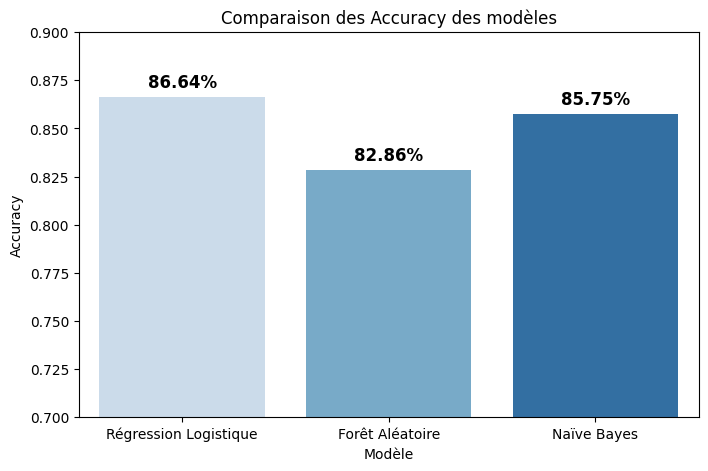

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


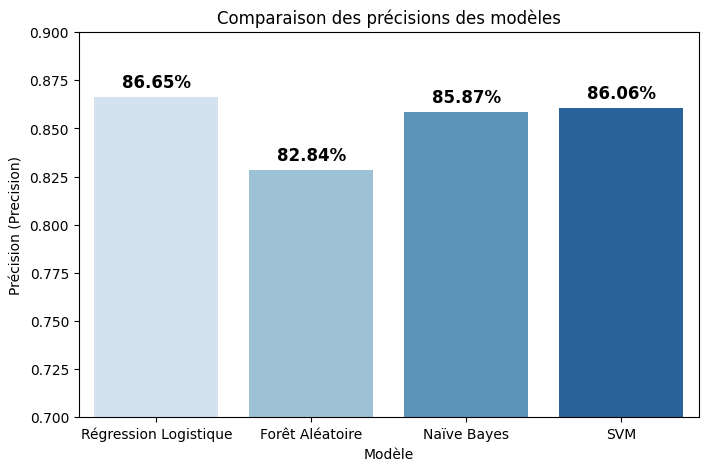

In [ ]:
accuracy_scores = {
    "Régression Logistique": accuracy_lr,
    "Forêt Aléatoire": accuracy_rf,
}


plt.figure(figsize=(8, 5))
ax = sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()), palette="Blues")


for i, v in enumerate(accuracy_scores.values()):
    ax.text(i, v + 0.005, f"{v:.2%}", ha='center', fontsize=12, fontweight='bold')

plt.ylim(0.7, 0.9)  # Ajuste selon tes valeurs
plt.xlabel("Modèle")
plt.ylabel("Accuracy")
plt.title("Comparaison des Accuracy des modèles")
plt.show()


precision_scores = {
    "Régression Logistique": precision_score(y_test, predictions_lr, average="weighted"),
    "Forêt Aléatoire": precision_score(y_test, predictions_rf, average="weighted"),
}


plt.figure(figsize=(8, 5))
ax = sns.barplot(x=list(precision_scores.keys()), y=list(precision_scores.values()), palette="Blues")

for i, v in enumerate(precision_scores.values()):
    ax.text(i, v + 0.005, f"{v:.2%}", ha='center', fontsize=12, fontweight='bold')

plt.ylim(0.7, 0.9)  # Ajuste selon tes valeurs
plt.xlabel("Modèle")
plt.ylabel("Précision (Precision)")
plt.title("Comparaison des précisions des modèles")
plt.show()


## 9 - Visualisation des résultats

### Distribution des sentiments

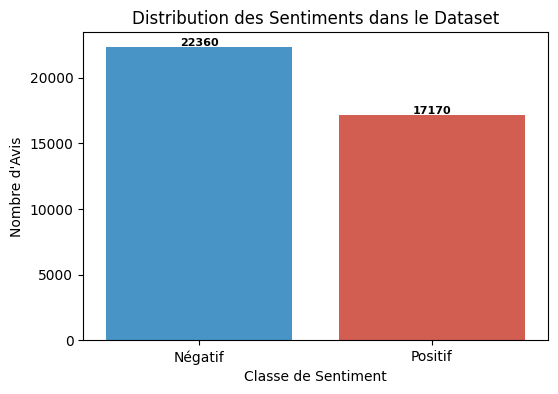

In [ ]:

sentiment_counts = df["Sentiment"].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=["#3498db", "#e74c3c"])

for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v + 50, str(v), ha="center", fontsize=8, fontweight="bold")

plt.xlabel("Classe de Sentiment")
plt.ylabel("Nombre d'Avis")
plt.title("Distribution des Sentiments dans le Dataset")
plt.xticks(ticks=[0, 1], labels=["Négatif", "Positif"])
plt.show()

#### Le fait que 4 étoiles soient considérés comme positifs joue un rôle, mais c'est surtout la présence des 3 étoiles dans la catégorie négative qui déséquilibre les données. Une classe neutre pourrait être une bonne alternative pour une analyse plus fine

### Interprétabilité basé la régression logistique

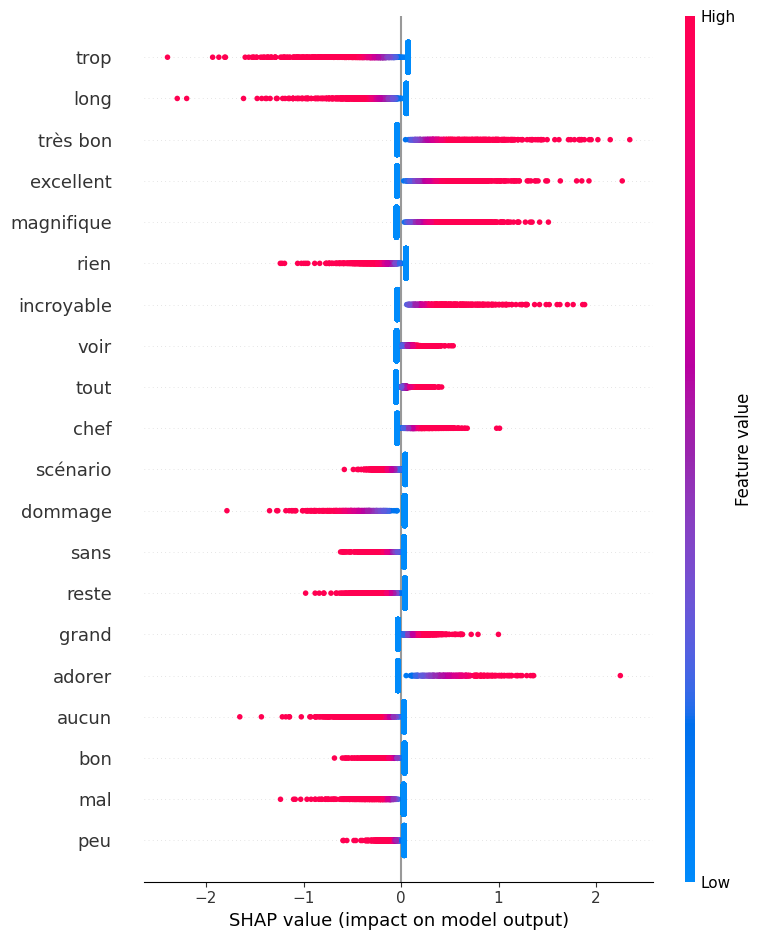

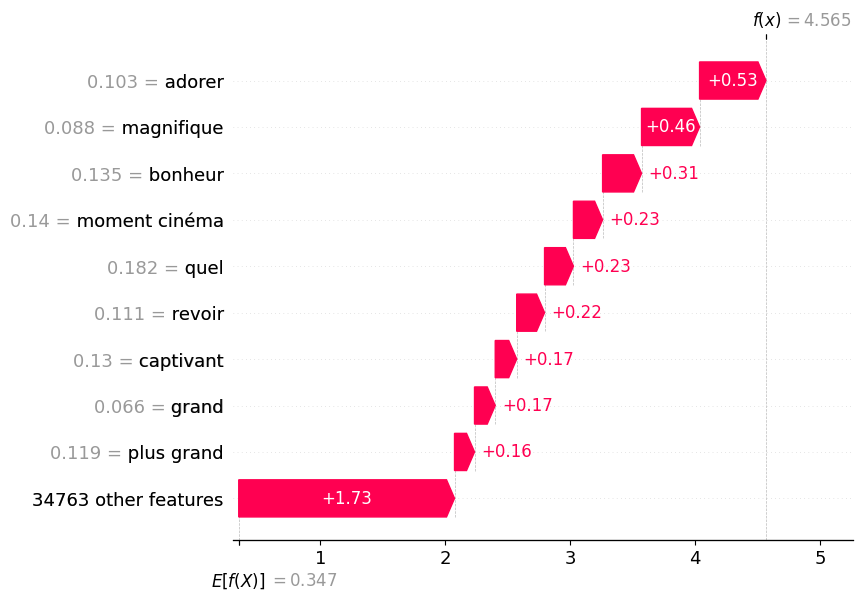

In [ ]:
X_train_dense = X_train.toarray()  # Conversion en format dense
X_test_dense = X_test.toarray()


try:
    feature_names = vectorizer_tfidf.get_feature_names_out()
except NameError:
    feature_names = None  # Si vectorizer n'est pas défini, utiliser None


explainer = shap.Explainer(model_lr, X_train_dense)

shap_values = explainer(X_test_dense)

shap.summary_plot(shap_values, X_test_dense, feature_names=feature_names)

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[0],  # Pour la classe 1 (ajuster si besoin)
        feature_names=vectorizer_tfidf.get_feature_names_out()
    )
)